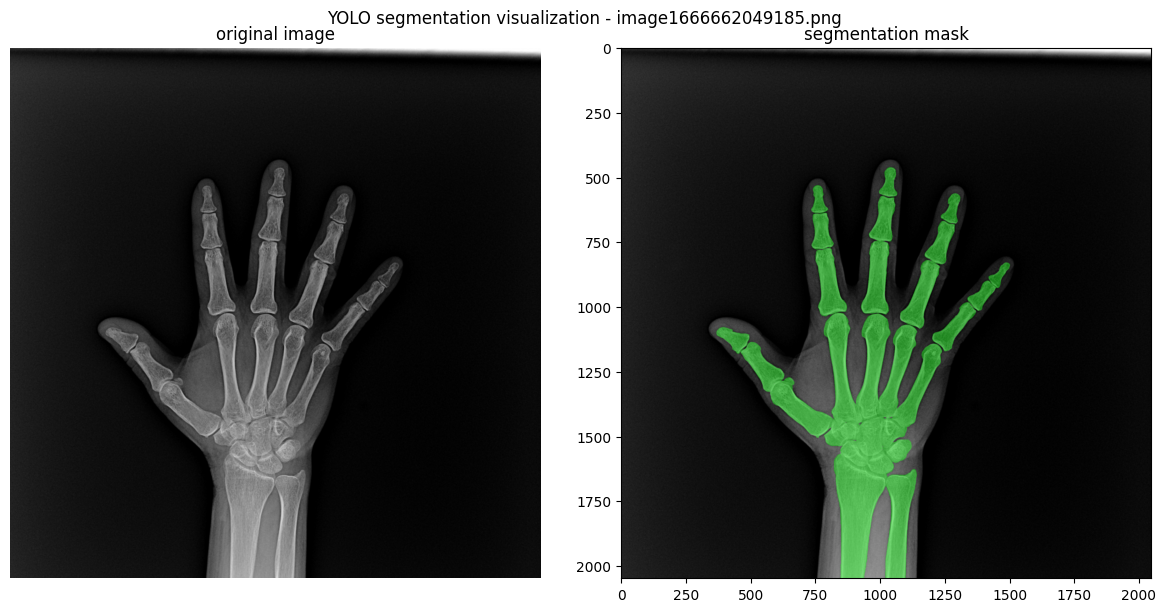

In [12]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

# YOLO 데이터셋 경로 설정
dataset_path = '/data/ephemeral/home/data/train_fold_1/yolo'
images_path = os.path.join(dataset_path, 'images')
labels_path = os.path.join(dataset_path, 'labels')

# 랜덤하게 이미지 선택
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))]
random_image = random.choice(image_files)
image_path = os.path.join(images_path, random_image)

# 해당하는 라벨 파일 경로
label_file = os.path.join(labels_path, random_image.rsplit('.', 1)[0] + '.txt')

# 이미지 읽기
img = cv2.imread(image_path)
height, width = img.shape[:2]

# 마스크 이미지 생성
mask_img = np.zeros((height, width), dtype=np.uint8)

# YOLO 포맷 라벨 읽기
if os.path.exists(label_file):
    with open(label_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            # YOLO 세그멘테이션 포맷에서 마스크 포인트 추출
            values = line.strip().split()
            class_id = int(values[0])
            points = []
            for i in range(1, len(values), 2):
                x = float(values[i]) * width
                y = float(values[i + 1]) * height
                points.append([int(x), int(y)])
            
            # 마스크 생성
            if len(points) > 2:
                points = np.array(points, dtype=np.int32)
                cv2.fillPoly(mask_img, [points], color=255)

# 시각화
plt.figure(figsize=(12, 6))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('original image')
plt.axis('off')

# 마스크가 적용된 이미지
plt.subplot(1, 2, 2)
overlay = img.copy()
overlay[mask_img > 0] = [0, 255, 0]  # 마스크 영역을 초록색으로 표시
alpha = 0.4
result = cv2.addWeighted(img, 1-alpha, overlay, alpha, 0)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('segmentation mask')

plt.suptitle(f'YOLO segmentation visualization - {random_image}')
plt.tight_layout()
plt.show()

In [3]:
import os

# 이미지 디렉토리 경로 설정
image_dir = '/data/ephemeral/home/data/train_fold_1/DCM/'

# 디렉토리 내의 모든 PNG 파일 검사
for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        image_path = os.path.join(image_dir, filename)
        img = cv2.imread(image_path)
        
        # 이미지 크기가 2048x2048이 아닌 경우 파일명 출력
        if img.shape[0] != 2048 or img.shape[1] != 2048:
            print(f'크기가 다른 이미지 발견: {filename} - 크기: {img.shape[1]}x{img.shape[0]}')


KeyboardInterrupt: 

/tmp/ipykernel_349634/2734587493.py:81: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_349634/2734587493.py:81: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_349634/2734587493.py:81: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_349634/2734587493.py:81: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_349634/2734587493.py:81: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_349634/2734587493.py:81: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_349634/2734587493.py:81: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
 

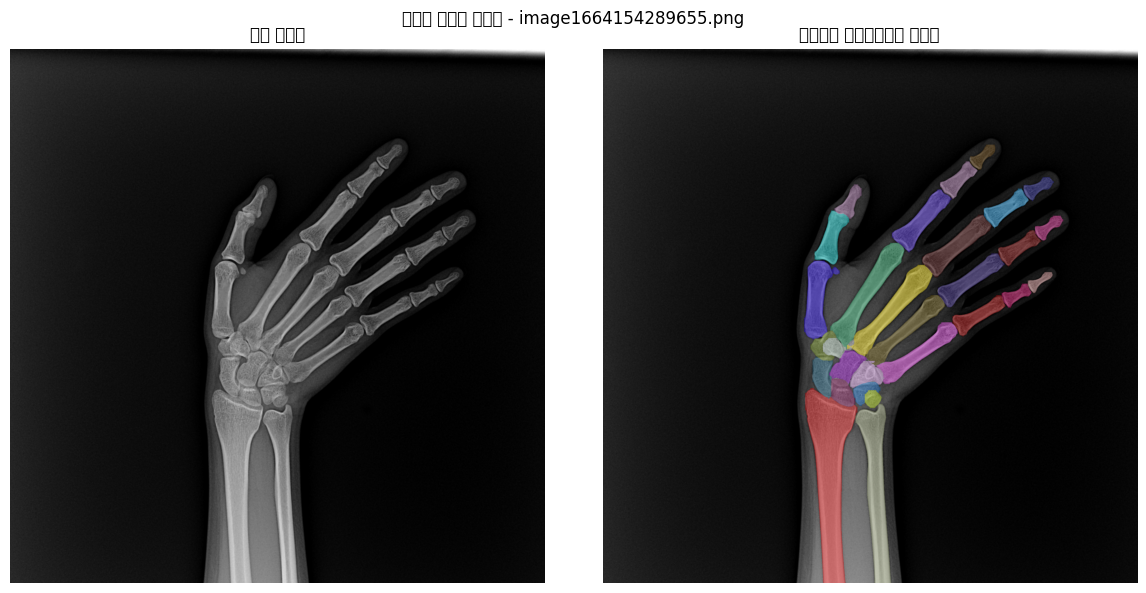

발견된 클래스:
- finger-6 (RGB: (220, 20, 60))
- finger-8 (RGB: (165, 42, 42))
- finger-15 (RGB: (0, 80, 100))
- finger-10 (RGB: (0, 0, 70))
- finger-4 (RGB: (0, 60, 100))
- finger-9 (RGB: (250, 170, 30))
- finger-13 (RGB: (0, 0, 142))
- finger-7 (RGB: (100, 170, 30))
- finger-14 (RGB: (119, 11, 32))
- finger-17 (RGB: (106, 0, 228))
- finger-19 (RGB: (255, 77, 255))
- Radius (RGB: (0, 0, 230))
- finger-2 (RGB: (220, 220, 0))
- finger-5 (RGB: (175, 116, 175))
- finger-16 (RGB: (182, 182, 255))
- finger-18 (RGB: (0, 0, 192))
- finger-11 (RGB: (0, 226, 252))
- Scaphoid (RGB: (110, 76, 0))
- Ulna (RGB: (120, 166, 157))
- finger-3 (RGB: (250, 0, 30))
- finger-4 (RGB: (0, 60, 100))
- Trapezium (RGB: (0, 125, 92))
- Triquetrum (RGB: (199, 100, 0))
- Lunate (RGB: (72, 0, 118))
- Trapezoid (RGB: (188, 208, 182))
- Capitate (RGB: (209, 0, 151))
- Hamate (RGB: (255, 179, 240))
- Pisiform (RGB: (0, 220, 176))
- finger-12 (RGB: (174, 57, 255))
- finger-5 (RGB: (175, 116, 175))

총 발견된 클래스 개수: 30


In [11]:
# CSV 파일 읽기
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 팔레트 정의
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# CSV 파일 읽기
df = pd.read_csv('/data/ephemeral/home/kgs/level2-cv-semanticsegmentation-cv-8-lv3/Ultralytics/test.csv')

# 이미지 디렉토리 경로
image_dir = '/data/ephemeral/home/data/test/DCM'

# 랜덤하게 이미지 하나 선택
random_image = df['image_name'].sample(n=1).iloc[0]

# 해당 이미지의 모든 클래스와 RLE 가져오기
image_data = df[df['image_name'] == random_image]

# 이미지 경로 찾기
image_path = None
for root, dirs, files in os.walk(image_dir):
    if random_image in files:
        image_path = os.path.join(root, random_image)
        break

if image_path:
    # 이미지 읽기
    img = cv2.imread(image_path)
    
    # RLE 디코딩하여 마스크 생성
    def decode_rle(rle_string, height=2048, width=2048):
        if pd.isna(rle_string):
            return np.zeros((height, width), dtype=np.uint8)
        
        s = rle_string.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(height * width, dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape((height, width))

    # 각 클래스별로 다른 색상의 마스크 생성
    overlay = img.copy()
    for idx, row in image_data.iterrows():
        mask = decode_rle(row['rle'])
        class_idx = df['class'].unique().tolist().index(row['class'])
        color = PALETTE[class_idx % len(PALETTE)]  # 팔레트에서 색상 선택
        overlay[mask > 0] = color  # BGR 순서로 색상 적용
    
    # 시각화
    plt.figure(figsize=(12, 6))
    
    # 원본 이미지
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('원본 이미지')
    plt.axis('off')
    
    # 마스크가 적용된 이미지
    plt.subplot(1, 2, 2)
    alpha = 0.4
    result = cv2.addWeighted(img, 1-alpha, overlay, alpha, 0)
    
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title(f'클래스별 세그멘테이션 마스크')
    plt.axis('off')
    
    plt.suptitle(f'테스트 데이터 시각화 - {random_image}')
    plt.tight_layout()
    plt.show()
    
    # 발견된 클래스 출력
    print("발견된 클래스:")
    for _, row in image_data.iterrows():
        class_idx = df['class'].unique().tolist().index(row['class'])
        color = PALETTE[class_idx % len(PALETTE)]
        print(f"- {row['class']} (RGB: {color})")
    
    # 발견된 클래스 개수 출력
    print(f"\n총 발견된 클래스 개수: {len(image_data)}")
else:
    print(f'이미지를 찾을 수 없습니다: {random_image}')
